# Initialization

- No user input required

In [4]:
import sys
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.set_printoptions(threshold=sys.maxsize) #print out full arrays
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

randomstate = 42

# Load data
## Input info

- Sets up script to pull parameters from excel
- Populate fields as indicated
- only populate D1_params, D2_params, D3_params if you want to update the parameters used to define chemical space from what is reported in the parent paper

In [5]:
# Parameters file
comp_file = "Parameters" # parameters excel filename
comp_sheet = "all_C2v" # parameters excel sheetname
num_par = 181 # Number of parameters
par_start_col = 2  # 0-indexed column number of first column with descriptors
comp_num_samples = 1050 # Number of ligands with descriptors
y_label_col_comp = 0  # 0-indexed, the ligand number of the ligand IDs

# if you would like to remove any ligands from the chemical space, add their ligand IDs to this list
remove_ligs = []

# Define the parameters to use in the electronic, steric and geometric axis.
D1_name, D2_name, D3_name = 'electronic', 'steric', 'geometric'
D1_params = ['x12', 'x128', 'x168', 'x121', 'x122', 'x112', 'x38', 'x169','x171'] 
D2_params = ['x142', 'x143', 'x148', 'x149']
D3_params = ['x69','x172']

## Pull parameters from excel 

- Pulls parameters from excel spreadsheet
- creates parameter_dict and labels_dict

In [6]:
# descriptors dataframe
compinp = pd.read_excel(comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,nrows=comp_num_samples+1,usecols=list(range(0,(num_par+par_start_col))),engine='openpyxl')
compinp.index = compinp.index.astype(str)

# Creates dictionary for ligand ID to Ligand Names
labels_df = compinp.smiles[1:]
IDs = list(labels_df.index)
names = list(labels_df)
labels_dict = dict(zip(IDs, names)) # keys: ligand IDs (str), values: ligand names (str)

# Creates dictionary for parameter id ('x1', 'x20', etc) to the parameter name
param_nums = list(compinp.columns)[1:]
param_names = list(compinp.iloc[0][1:])
param_dict = dict(zip(param_nums, param_names)) # keys: param #s (e.g. 'x1','x2'), values: param names (str)

# Removes ligand names and parameter names. 
compinp = compinp.drop(['smiles'],axis=1)
compinp.drop(index=compinp.index[0],inplace=True)

# removes enantiomer parameters
for i in compinp.index:
    if '_1' in i:
        compinp.drop(i, inplace=True)
for i in remove_ligs:
    compinp.drop(i, inplace=True)
ligand_ids = list(compinp.index)  # Ligand ids after curation

# Create condensed dataframe with parameters selected for D1, D2, and D3
condensed_compinp = compinp[D1_params + D2_params + D3_params]

condensed_compinp.head()


,x12,x128,x177,x121,x122,x112,x38,x178,x180,x142,x143,x148,x149,x69,x181
x,,,,,,,,,,,,,,,
138,123.78575,42.58,1.96033,0.04624,0.04624,0.24276,0.07054,-0.28935,-0.3093,38.066354,45.972971,11.728012,35.075414,315.25407,94.171685
303,151.92635,43.83,1.96022,0.05646,0.05741,0.22522,0.08554,-0.29848,-0.30513,35.460797,43.0731,4.946931,23.937062,314.463193,95.284977
312,130.63245,42.79,1.96827,0.04197,0.04338,0.22461,0.07517,-0.29454,-0.30447,43.58146,51.069662,18.055987,46.899634,318.061423,99.536997
349,99.31315,44.67,1.9655,0.03689,0.03962,0.24623,0.07783,-0.29185,-0.3079,29.77491,37.158366,17.078394,25.808454,313.471349,92.059532
374,153.8721,47.85,1.96218,0.04124,0.05308,0.22122,0.07857,-0.29051,-0.30641,35.62674,52.944843,7.224877,45.363416,310.444014,101.487041


## Run PCA Analysis

- Runs PCA for three separate bins of parameters (steric, electronic, geometric)
- Plots first PC of each bin and prints PCA statistics
- No user input required

Electronic parameters :
['aniso_P_NMR_avg', 'NoPd_LP_P_s_max', 'Pd_LP_3_occ', 'NoPd_P_RBack_antibond_occ_min', 'NoPd_P_RBack_antibond_occ_max', 'NoPd_P_R_antibond_eng_min', 'P_R_antibond_occ_max', 'Pd_LP_3_eng', 'Pd_LP_4_eng']

Steric parameters :
['quadrants_7.0_Ang_min', 'quadrants_7.0_Ang_max', 'octants_4.0_Ang_min', 'octants_4.0_Ang_max']

Geometric parameters :
['X_Angle_Sum_avg', 'bite_angle']


ELECTRONIC: 57 % of the electronic variance is explained by two principle components
STERIC: 86 % of the steric variance is explained by two principle components
GEOMETRIC: 100 % of the geometric variance is explained by two principle components


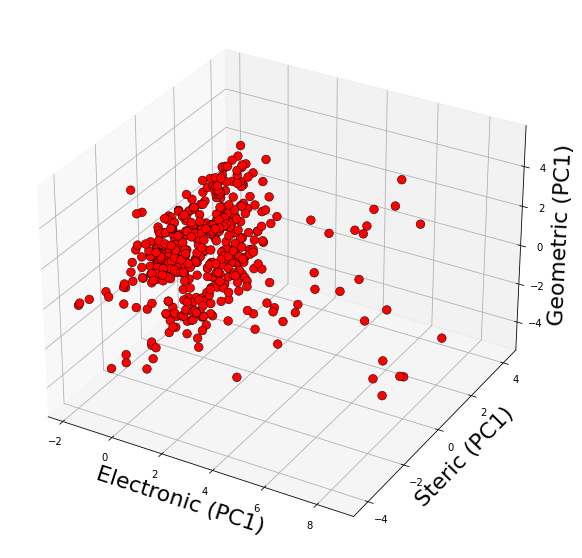

In [7]:
n_pcs = 2 # Number of principle components

# Scale the condensed data 
scaler = StandardScaler().fit(condensed_compinp)
X_all_scaler = scaler.transform(condensed_compinp)

# Create numpy arrays for scaled D1, D2, and D3 parameter sets
D1_param_loc = [condensed_compinp.columns.get_loc(i) for i in D1_params if i in condensed_compinp.columns]
D2_param_loc = [condensed_compinp.columns.get_loc(i) for i in D2_params if i in condensed_compinp.columns]
D3_param_loc = [condensed_compinp.columns.get_loc(i) for i in D3_params if i in condensed_compinp.columns]

X_D1 = X_all_scaler[:,D1_param_loc]
X_D2 = X_all_scaler[:,D2_param_loc]
X_D3 = X_all_scaler[:,D3_param_loc]

# PCA of each dimension and chemcial space formation
pca_D1_trans, pca_D2_trans, pca_D3_trans = PCA(n_components=n_pcs).fit(X_D1), PCA(n_components=n_pcs).fit(X_D2), PCA(n_components=n_pcs).fit(X_D3)
X_D1_pca, X_D2_pca, X_D3_pca = pca_D1_trans.transform(X_D1), pca_D2_trans.transform(X_D2), pca_D3_trans.transform(X_D3)
Chemical_Space = np.hstack((X_D1_pca, X_D2_pca, X_D3_pca)) # Numpy array of chemical space
Chemical_Space_df = pd.DataFrame(data=Chemical_Space, index=condensed_compinp.index, 
                                 columns=[D1_name + str(i+1) for i in range(n_pcs)] + [D2_name + str(i+1) for i in range(n_pcs)] + [D3_name + str(i+1) for i in range(n_pcs)]) # DataFrame of Chemical Space Map


# print out PCA information
D1_score, D2_score, D3_score = pca_D1_trans.explained_variance_ratio_, pca_D2_trans.explained_variance_ratio_, pca_D3_trans.explained_variance_ratio_
D1_score, D2_score, D3_score = sum([D1_score[i] for i in range(n_pcs)]), sum([D2_score[i] for i in range(n_pcs)]), sum([D3_score[i] for i in range(n_pcs)])
print('{} parameters :\n{}\n'.format(D1_name.capitalize(), [param_dict[k] for k in D1_params]))
print('{} parameters :\n{}\n'.format(D2_name.capitalize(), [param_dict[k] for k in D2_params]))
print('{} parameters :\n{}\n\n'.format(D3_name.capitalize(), [param_dict[k] for k in D3_params]))
print('{}: {:.0f} % of the {} variance is explained by two principle components'.format(D1_name.upper(), D1_score*100, D1_name))
print('{}: {:.0f} % of the {} variance is explained by two principle components'.format(D2_name.upper(), D2_score*100, D2_name))
print('{}: {:.0f} % of the {} variance is explained by two principle components'.format(D3_name.upper(), D3_score*100, D3_name))

# Plot PCA Space
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Chemical_Space[:,0],Chemical_Space[:,0 + n_pcs],Chemical_Space[:,0 + 2*n_pcs], c='red',alpha=1,marker=".",s=300,edgecolor="black",linewidth=0.5)
x_max, x_min, y_max, y_min, z_max, z_min = max(Chemical_Space[:,0]), min(Chemical_Space[:,0]), max(Chemical_Space[:,1]), min(Chemical_Space[:,1]), max(Chemical_Space[:,2]), min(Chemical_Space[:,2])
x_range, y_range, z_range = x_max - x_min, y_max - y_min, z_max - z_min
ax.set_xlim3d(x_min - 0*x_range, x_max + 0*x_range)
ax.set_ylim3d(y_min - 0*y_range, y_max + 0*y_range)
ax.set_zlim3d(z_min - 0*z_range, z_max + 0*z_range)


ax.set_xlabel('Electronic (PC1)', fontsize=22)
ax.set_ylabel('Steric (PC1)', fontsize=22)
ax.set_zlabel('Geometric (PC1)', fontsize=22)
plt.savefig("pca 3d subset.png",dpi=300)
plt.show()



## Plot a subset of ligands in Curated Chemical Space

- Sets up script to plot subsets of ligands
- populate example lists
- populate example_dict

In [8]:
# Define lists of ligand IDs to plot in chemical space.

example_list_1 = ['150', '711', '716', '24', '18', '392', '564', '606', '710', '97', '48', '147',  '196', '717',
          '709','712', '189', '708', '707', '306'] 

example_list_2 = ['481', '251', '383', '721', '16', '178', '175', '306', '719', '14', '478', '475', '12']

example_list_3 = ['8', '10', '12', '14', '16', '18', '19', '22']


# If you would like to plot a heatmap of a particular output, you can add this as a dictionary with keys = ligand ids, and values = experimental output.
example_dict = {'12': 97,'481': 40, '251': 50, '383': 30, '721': 55, '16': 87, '178': 57, '175': 82, '306': 67, '719': 60, '14': 100, '478': 100, '475': 100, '500': 100, '722': 80, '301': 1, '488': 2, '24': 3, '18': 4, '480': 5, '177': 5, '505': 5, '305': 5, '10': 7, '504': 7, '299': 10, '302': 12}


## Define Plotting Functions

- Defines plotting functions, ligands to use, and plot-point labels
- populate subset labels
- populate subset ids
- populate sub_hmap_dict

In [9]:
# Name of ligand subsets for plot legend (e.g. 'Training Set' or 'test set')
sub0_label = 'example_list_1' 
sub1_label = 'example_list_2'
sub2_label = 'example_list_3'


# define subsets with list of ligand ID (e.g. ['8', '14', '301', ...])
sub0_ids = example_list_1 
sub1_ids = example_list_2
sub2_ids = example_list_3
sub_hmap_dict = example_dict # dictionary with key = ids, values = experimental output


######## No user input below this line #########
sub_hmap_ids = sub_hmap_dict.keys()
sub_hmap_values = list(sub_hmap_dict.values())

# Creates a dataframe of the subset parameters
condensed_compinp_sub0 = condensed_compinp.loc[sub0_ids]
condensed_compinp_sub1 = condensed_compinp.loc[sub1_ids]
condensed_compinp_sub2 = condensed_compinp.loc[sub2_ids]
condensed_compinp_sub_hmap = condensed_compinp.loc[sub_hmap_ids]

# Scales parameters and converts to D1/D2/D3 Coordinates
X_sub0_scaler = scaler.transform(condensed_compinp_sub0)
X_sub1_scaler = scaler.transform(condensed_compinp_sub1)
X_sub2_scaler = scaler.transform(condensed_compinp_sub2)
X_sub_hmap_scaler = scaler.transform(condensed_compinp_sub_hmap)
X_D1_sub0, X_D1_sub1, X_D1_sub2, X_D1_sub_hmap =X_sub0_scaler[:,D1_param_loc], X_sub1_scaler[:,D1_param_loc], X_sub2_scaler[:,D1_param_loc], X_sub_hmap_scaler[:,D1_param_loc]
X_D2_sub0, X_D2_sub1, X_D2_sub2, X_D2_sub_hmap = X_sub0_scaler[:,D2_param_loc],X_sub1_scaler[:,D2_param_loc], X_sub2_scaler[:,D2_param_loc], X_sub_hmap_scaler[:,D2_param_loc]
X_D3_sub0, X_D3_sub1, X_D3_sub2, X_D3_sub_hmap = X_sub0_scaler[:,D3_param_loc], X_sub1_scaler[:,D3_param_loc], X_sub2_scaler[:,D3_param_loc], X_sub_hmap_scaler[:,D3_param_loc]
X_D1_sub0_pca, X_D2_sub0_pca, X_D3_sub0_pca = pca_D1_trans.transform(X_D1_sub0), pca_D2_trans.transform(X_D2_sub0), pca_D3_trans.transform(X_D3_sub0)
X_D1_sub1_pca, X_D2_sub1_pca, X_D3_sub1_pca = pca_D1_trans.transform(X_D1_sub1), pca_D2_trans.transform(X_D2_sub1), pca_D3_trans.transform(X_D3_sub1)
X_D1_sub2_pca, X_D2_sub2_pca, X_D3_sub2_pca = pca_D1_trans.transform(X_D1_sub2), pca_D2_trans.transform(X_D2_sub2), pca_D3_trans.transform(X_D3_sub2)
X_D1_sub_hmap_pca, X_D2_sub_hmap_pca, X_D3_sub_hmap_pca = pca_D1_trans.transform(X_D1_sub_hmap), pca_D2_trans.transform(X_D2_sub_hmap), pca_D3_trans.transform(X_D3_sub_hmap)


# Function plots multiple subsets on a chemical space map (2D)
# For argument details see following cell
def plot_2D_X_Section(D1, D2, plot_all_library=True, plot_sub0=False, plot_sub1=False, plot_sub2=False, 
                      plot_sub_hmap=False, savefile=True, leg=True, annotate_sub0=False, annotate_sub1=False):
    plot_dict_all_library = { 'electronic': Chemical_Space[:,0], 'steric' : Chemical_Space[:,2], 'geometric' : Chemical_Space[:,4]}
    plot_dict_sub0 = { 'electronic': X_D1_sub0_pca[:,0], 'steric' : X_D2_sub0_pca[:,0], 'geometric' : X_D3_sub0_pca[:,0]}
    plot_dict_sub1 = { 'electronic': X_D1_sub1_pca[:,0], 'steric' : X_D2_sub1_pca[:,0], 'geometric' : X_D3_sub1_pca[:,0]}
    plot_dict_sub2 = { 'electronic': X_D1_sub2_pca[:,0], 'steric' : X_D2_sub2_pca[:,0], 'geometric' : X_D3_sub2_pca[:,0]}
    plot_dict_hmap = { 'electronic': X_D1_sub_hmap_pca[:,0], 'steric' : X_D2_sub_hmap_pca[:,0], 
                      'geometric' : X_D3_sub_hmap_pca[:,0]}

    
    plot_x_all_library, plot_y_all_library = plot_dict_all_library[D1.lower()], plot_dict_all_library[D2.lower()]
    plot_x_sub0, plot_y_sub0 = plot_dict_sub0[D1.lower()], plot_dict_sub0[D2.lower()]
    plot_x_sub1, plot_y_sub1  = plot_dict_sub1[D1.lower()], plot_dict_sub1[D2.lower()]
    plot_x_sub2, plot_y_sub2 = plot_dict_sub2[D1.lower()], plot_dict_sub2[D2.lower()]
    plot_x_hmap, plot_y_hmap = plot_dict_hmap[D1.lower()], plot_dict_hmap[D2.lower()]


    # Plot Electronic vs Steric
    fig = plt.figure(figsize=(8,7.5))
    ax = fig.add_subplot(111)

    if plot_all_library:
        ax.scatter(plot_x_all_library,plot_y_all_library,label='Virtual Library', c = 'black' ,alpha=.1, 
                   marker=".",s=150,edgecolor="black",linewidth=0.5)
    if plot_sub0:
        ax.scatter(plot_x_sub0, plot_y_sub0, label=sub0_label, c='Blue', marker="o", edgecolors = 'black', s=200,alpha=.9)
    if plot_sub1:
        ax.scatter(plot_x_sub1, plot_y_sub1, label=sub1_label, c='Red', alpha=0.9,marker="o", s=200, edgecolors="black",
                   linewidth=0.9)
    if plot_sub2:
        ax.scatter(plot_x_sub2, plot_y_sub2, label=sub2_label, c='White', alpha=1,marker="o",s=400,edgecolor="black",
                   linewidth=0.9)
    if plot_sub_hmap:
        p = ax.scatter(plot_x_hmap,plot_y_hmap, c=sub_hmap_values, cmap='YlOrRd', alpha=.75,marker="o",s=100 ,edgecolor="black",
                       linewidth=0.5)
        cbar = fig.colorbar(p, fraction=0.1, pad = 0.1)
        cbar.set_label('Enantioselectivity (kcal)',rotation=90,size=30,labelpad=10) 

    if annotate_sub0:
        for index, ID in enumerate(sub0_ids):
            lig_name = labels_dict[str(ID)]
            ax.annotate(lig_name, (X_D1_sub0_pca[index,0], X_D2_sub0_pca[index,0]), fontsize='8', c = 'black')
    if annotate_sub1:
        for index, ID in enumerate(sub1_ids):
            lig_name = labels_dict[str(ID)]
            plt.annotate(lig_name, (X_D1_sub1_pca[index,0], X_D2_sub1_pca[index,0]), fontsize='8', c = 'black')
    if leg:  
        ax.legend(fontsize=25)
    plt.xlabel(D1, fontsize=36, fontname = 'Helvetica', labelpad=1)
    plt.ylabel(D2, fontsize=36, fontname = 'Helvetica', labelpad=1)
    #plt.locator_params(axis='x', nbins=5)
    #plt.locator_params(axis='y', nbins=5)
    #plt.xlim(-3.5, 3.5)
    #plt.ylim(-3.5, 3.5)
    plt.xticks(fontsize=25, fontname = 'Helvetica') 
    plt.yticks(fontsize=25, fontname = 'Helvetica')
    plt.rcParams['axes.linewidth'] = 2
    plt.tight_layout()  
    if savefile:
        plt.savefig('2D_{}_{}.png'.format(D1, D2), dpi=500)
    plt.show()  




## Run Plotting Function

- Runs plotting functions
- Populate arguments within plotting function

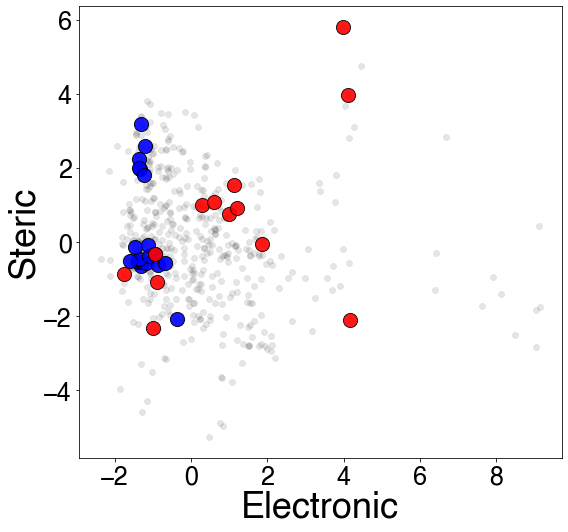

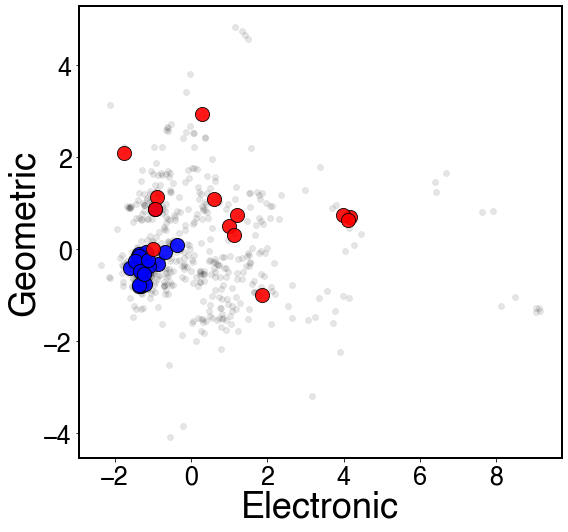

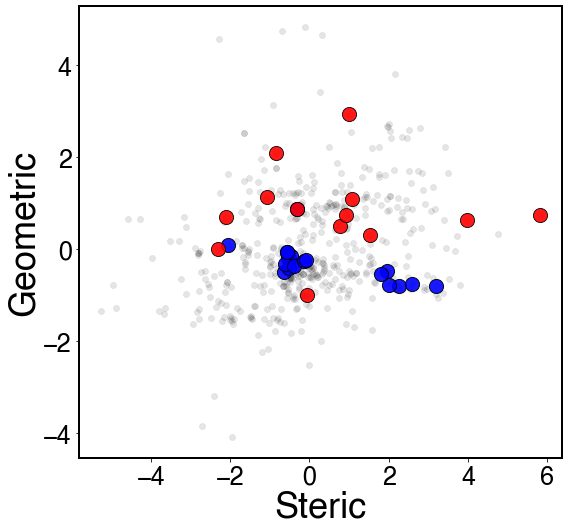

In [10]:
# Run plot_2D_X_Section with the following args:
# 'Electronic/Steric/Geometric'- tells script which dimension to plot on the y-axis
# 'Electronic/Steric/Geometric' - tells the script which dimension to plot on the x-axis
# plot_sub0 = T/F, plot_sub1 = T/F, plot_sub2 = T/F - (tells the script whether or not to plot subsets 0, 1, and/or 2)
# plot_sub_hmap = T/F - tells the script whether or not to plot a heatmap
# savefile = T/F - tells the script to save/not save
# leg = T/F - tells script if you want to include a legend 

# Plot Steric/Electronic Cross-Section
plot_2D_X_Section('Electronic', 'Steric', 
                  plot_all_library=True, plot_sub0=True, plot_sub1=True,
                  plot_sub2=False, plot_sub_hmap=False, savefile=False,
                  leg=False, annotate_sub0=False, annotate_sub1=False)

# Plot Geometric/Electronic Cross-Section
plot_2D_X_Section('Electronic', 'Geometric', plot_all_library=True, 
                  plot_sub0=True, plot_sub1=True, plot_sub2=False, 
                  plot_sub_hmap=False, savefile=True, leg=False,
                  annotate_sub0=False, annotate_sub1=False)

# Plot Steric/Geometric Cross-Section
plot_2D_X_Section('Steric', 'Geometric', plot_all_library=True,
                  plot_sub0=True, plot_sub1=True, plot_sub2=False, 
                  plot_sub_hmap=False, savefile=False, leg=False, 
                  annotate_sub0=False, annotate_sub1=False)


# Neighbour analysis 
## Define function

- Defines function to identify average cartesian distance from each lignad in one list (validation set) to the nearest n neighbors in another list (training set)
- No user input required

In [11]:
# training_set_ids = ligand ids of the training set
# validation_set_ids = ligand ids of the validation set
# k_keep = number of nearest neighbors to consider
# chemical_space = dataframe with chemical space PCs
# Returns:
# n_nearest_dict: Key = validation ID, value = average distance to n nearest TS neighbors
# n_nearest_lst: list of average distance to n nearest TS neighbors for each validation ligand
# avg_dist = the average distance of the n_nearest_lst
def k_nearest_neighbors(training_set_ids, validation_set_ids, k_keep, chemical_space):
    n_neighbors_keep = k_keep
    X_neighbors = chemical_space 
    n_neighbors = X_neighbors.shape[0]      # how many neighbor distances need to be computed
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute').fit(X_neighbors)
    distances, indices = nbrs.kneighbors(X_neighbors)

    n_nearest_dict = {} 
    n_nearest_lst = []

    for lig in validation_set_ids:
        query = lig         # ligand ID (labels in the descriptor file)
        dist_lst_i = []
        y_labels = np.asarray(list(compinp.index),dtype=str) # the ligand ids from the descriptor file
        q_nbrs = indices[np.where(y_labels == query)][0] # indices of nearest neighbors to lig ranked in ascending distance
        q_nbrs_label = [y_labels[i] for i in q_nbrs] # the IDs of nearest neighbors to lig ranked in ascending distance
        
        # Iterates through distances to all ligands in library keeps the distance if it corresponds to TS ligand
        for i in range(1,len(q_nbrs)):
            if q_nbrs_label[i] in training_set_ids:
                index_i = q_nbrs_label[i] # keeps ligand ID
                dist_i = round(distances[np.where(y_labels == query)][0][i], 2) 
                dist_lst_i.append(dist_i)
        dist_lst_i = dist_lst_i[:k_keep] # list of n nearest TS ligands in ascending order
        avg_dist_i = round(sum(dist_lst_i)/len(dist_lst_i), 2) # average distance n nearest TS ligands 
        n_nearest_dict[query] = avg_dist_i
        n_nearest_lst.append(avg_dist_i)
        avg_dist = round(sum(n_nearest_lst)/len(n_nearest_lst),2)
    
    return(n_nearest_dict, n_nearest_lst, avg_dist)

## Distances of test set ligands to nearest training set ligand

- TS = list of ligand ids in the training set
- VS = list of ligand ids in the validation set


In [25]:
# Define training and validation lists
TS = ['711', '18', '150', '606', '24', '392', '716', '23', '147', '97', '140', '306', '717', '712', '710', '48', '564', '709', '707', '708', '196', '189']
VS = ['143', '599', '568', '138', '561', '327', '679', '604', '273', '668', '612', '584', '704', '605', '669', '263', '667', '702', '706', '575', '573', '572', '560', '647', '569', '550', '588', '192', '19', '114', '601', '593', '583', '590']

# Run function
exval_dist_dict, exval_dist_list, exval_avg_dist = k_nearest_neighbors(TS,VS, 1, Chemical_Space)

print(exval_dist_dict)

{'143': 0.21, '599': 0.22, '568': 0.26, '138': 0.3, '561': 0.37, '327': 0.38, '679': 0.38, '604': 0.46, '273': 0.53, '668': 0.61, '612': 0.66, '584': 0.66, '704': 0.74, '605': 0.76, '669': 0.81, '263': 0.89, '667': 0.9, '702': 0.92, '706': 1.04, '575': 1.14, '573': 1.21, '572': 1.25, '560': 1.28, '647': 1.32, '569': 1.72, '550': 1.77, '588': 1.97, '192': 1.97, '19': 1.99, '114': 1.99, '601': 0.98, '593': 1.27, '583': 2.71, '590': 2.89}
